# Adding your own custom high-fidelity solver

Advanced users may want to substitute the default solvers in `rose` for their own custom ones. This tutorial will walk through that process, with scattering of 14.1 MeV neutrons on $^{27}$Al, using the [Koning-Delaroche](https://www.sciencedirect.com/science/article/pii/S0375947402013210?casa_token=qS1v6U4xDQEAAAAA:NIi9D5LpP3f05AMwRnvbQ6or8hSvXoEIgKBV56KA4l9aObCOVDAndmuCeIH77iuzoXMOOlAMyw) optical potential for the proton-nucleus interaction. 

We will add [this solver](https://pypi.org/project/lagrange-rmatrix/), which uses the calculable R-matrix method on a Lagrange-Legendre mesh. In principle, this should provide a very precise solver, that is also capable of non-local and coupled-channels potentials. 

In [1]:
import rose
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import pickle
from tqdm import tqdm

In [2]:
# !pip install jitr
import jitr
from numba import njit

In [3]:
# set up kinematics
from rose.koning_delaroche import KDGlobal, Projectile

# for 27-Al
A = 27
Z = 13

# lab bombarding energy
Elab = 35  # MeV

# get kinematics and default KD params
omp = rose.koning_delaroche.KDGlobal(Projectile.neutron)
(mu, Ecom, k, eta, R_C), parameters = omp.get_params(A, Z, Elab)

In [4]:
# create an interaction space for partial waves
interactions = rose.InteractionSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=len(parameters),
    mu=mu,
    energy=Ecom,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    Z_1=0,
    Z_2=13,
    R_C=R_C,
    l_max=15,
)

To use the `lagrange-rmatrix` package as a custom solver in `rose`, we will need to add a new derived class of `rose.SchroedingerEquation`, like so:

In [5]:
@njit
def potential(r, l, l_dot_s, params, v_r, v_so):
    return v_r(r, params) + v_so(r, params, l_dot_s)


class LagrangeRmatrix1ch(rose.SchroedingerEquation):
    r"""Implements a ROSE HF solver for an interaction with defined energy and l using jitr."""

    def __init__(
        self,
        interaction: rose.Interaction,
        sys: jitr.ProjectileTargetSystem,
        Nbasis: int,
    ):
        assert sys.nchannels == 1
        self.interaction = interaction
        self.sys = jitr.ProjectileTargetSystem(
            sys.reduced_mass,
            sys.channel_radii,
            np.array([interaction.ell]),
            sys.Ztarget,
            sys.Zproj,
            1,
        )

        self.ch = self.sys.build_channels(interaction.energy)
        self.solver = jitr.LagrangeRMatrixSolver(
            Nbasis,
            1,
            self.sys,
            ecom=interaction.energy,
            channel_matrix=self.ch,
            asym=jitr.CoulombAsymptotics,
        )
        
        self.domain = [0, self.sys.channel_radii[0]]
        self.s_0 = self.domain[1]

    def clone_for_new_interaction(self, interaction: rose.Interaction):
        return LagrangeRmatrix1ch(interaction, self.sys, self.solver.kernel.nbasis)

    def phi(
        self,
        alpha: np.array,
        s_mesh: np.array,
        **kwargs,
    ):
        im = jitr.InteractionMatrix(1)
        im.set_local_interaction(potential)
        im.local_args[0, 0] = (
            self.interaction.ell,
            self.interaction.spin_orbit_term.l_dot_s,
            alpha,
            self.interaction.v_r,
            self.interaction.spin_orbit_term.v_so,
        )
        R, S, x, uext_prime_boundary = self.solver.solve(
            im,
            self.ch,
            wavefunction=True,
        )
        return jitr.Wavefunctions(
            self.solver,
            x,
            S,
            uext_prime_boundary,
            self.sys.incoming_weights,
            self.ch,
            self.solver.asym,
        ).uint()[0](s_mesh)

    def smatrix(
        self,
        alpha: np.array,
        s_0: float = None,
        **kwargs,
    ):
        r"""
        Ignores s_0
        """
        im = jitr.InteractionMatrix(1)
        im.set_local_interaction(potential)
        im.local_args[0, 0] = (
            self.interaction.ell,
            self.interaction.spin_orbit_term.l_dot_s,
            alpha,
            self.interaction.v_r,
            self.interaction.spin_orbit_term.v_so,
        )
        R, S, uext_prime_boundary = self.solver.solve(im, self.ch)
        return S[0, 0]

    def rmatrix(
        self,
        alpha: np.array,
        s_0: float = None,
        **kwargs,
    ):
        r"""
        Ignores s_0
        """
        im = jitr.InteractionMatrix(1)
        im.set_local_interaction(potential)
        im.local_args[0, 0] = (
            self.interaction.ell,
            self.interaction.spin_orbit_term.l_dot_s,
            alpha,
            self.interaction.v_r,
            self.interaction.spin_orbit_term.v_so,
        )
        R, S, uext_prime_boundary = self.solver.solve(im, self.ch)
        return R[0, 0]

Let's set up the system:

In [6]:
nodes_within_radius = 3
s_0 = nodes_within_radius * (2 * np.pi) # channel matching radius

angles = np.linspace(1e-3, np.pi, 300)
s_mesh = np.linspace(1e-10, s_0, 1000)
domain = [s_mesh[0], s_0]

In [7]:
sys = jitr.ProjectileTargetSystem(
    np.array([mu]),
    np.array([nodes_within_radius * (2 * np.pi)]),
    l=np.array([0]),
    Ztarget=40,
    Zproj=0,
    nchannels=1,
)

In [8]:
llrm_solver = LagrangeRmatrix1ch(
    interactions.interactions[0][0],
    sys,
    300,
)

llrm = rose.ScatteringAmplitudeEmulator.HIFI_solver(
            interactions,
            base_solver=llrm_solver,
            angles=angles,
            s_mesh=s_mesh,
)

In [9]:
# choose the highest fidelity Runge-Kutta solver as our 'ground truth'
rk_domain = [domain[0], domain[1] + np.pi]  # extend rk domain past s_0
hifi_solver = rose.SchroedingerEquation.make_base_solver(
        rk_tols=[1e-11, 1e-11], s_0=s_0, domain=rk_domain
)
ground_truth = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions,
    base_solver=hifi_solver,
    angles=angles,
    s_mesh=s_mesh,
)

And that's it, we have our high-fidelity Lagrange-Legendre R-matrix solver and a Runge-Kutta solver. Let's compare them. 

In [10]:
solutions_llrm = llrm.exact_wave_functions(parameters)

In [11]:
solutions_rk = ground_truth.exact_wave_functions(parameters)

First, let's compare partial waves without phase matching:

(<Figure size 2700x1200 with 2 Axes>,
 <AxesSubplot: xlabel='$s = kr$ [dimensionless]', ylabel='$\\mathfrak{Re} \\, u_{lj}(s)$ [a.u.]'>,
 <AxesSubplot: xlabel='$s = kr$ [dimensionless]', ylabel='$\\mathfrak{Im} \\, u_{lj}(s)$ [a.u.]'>)

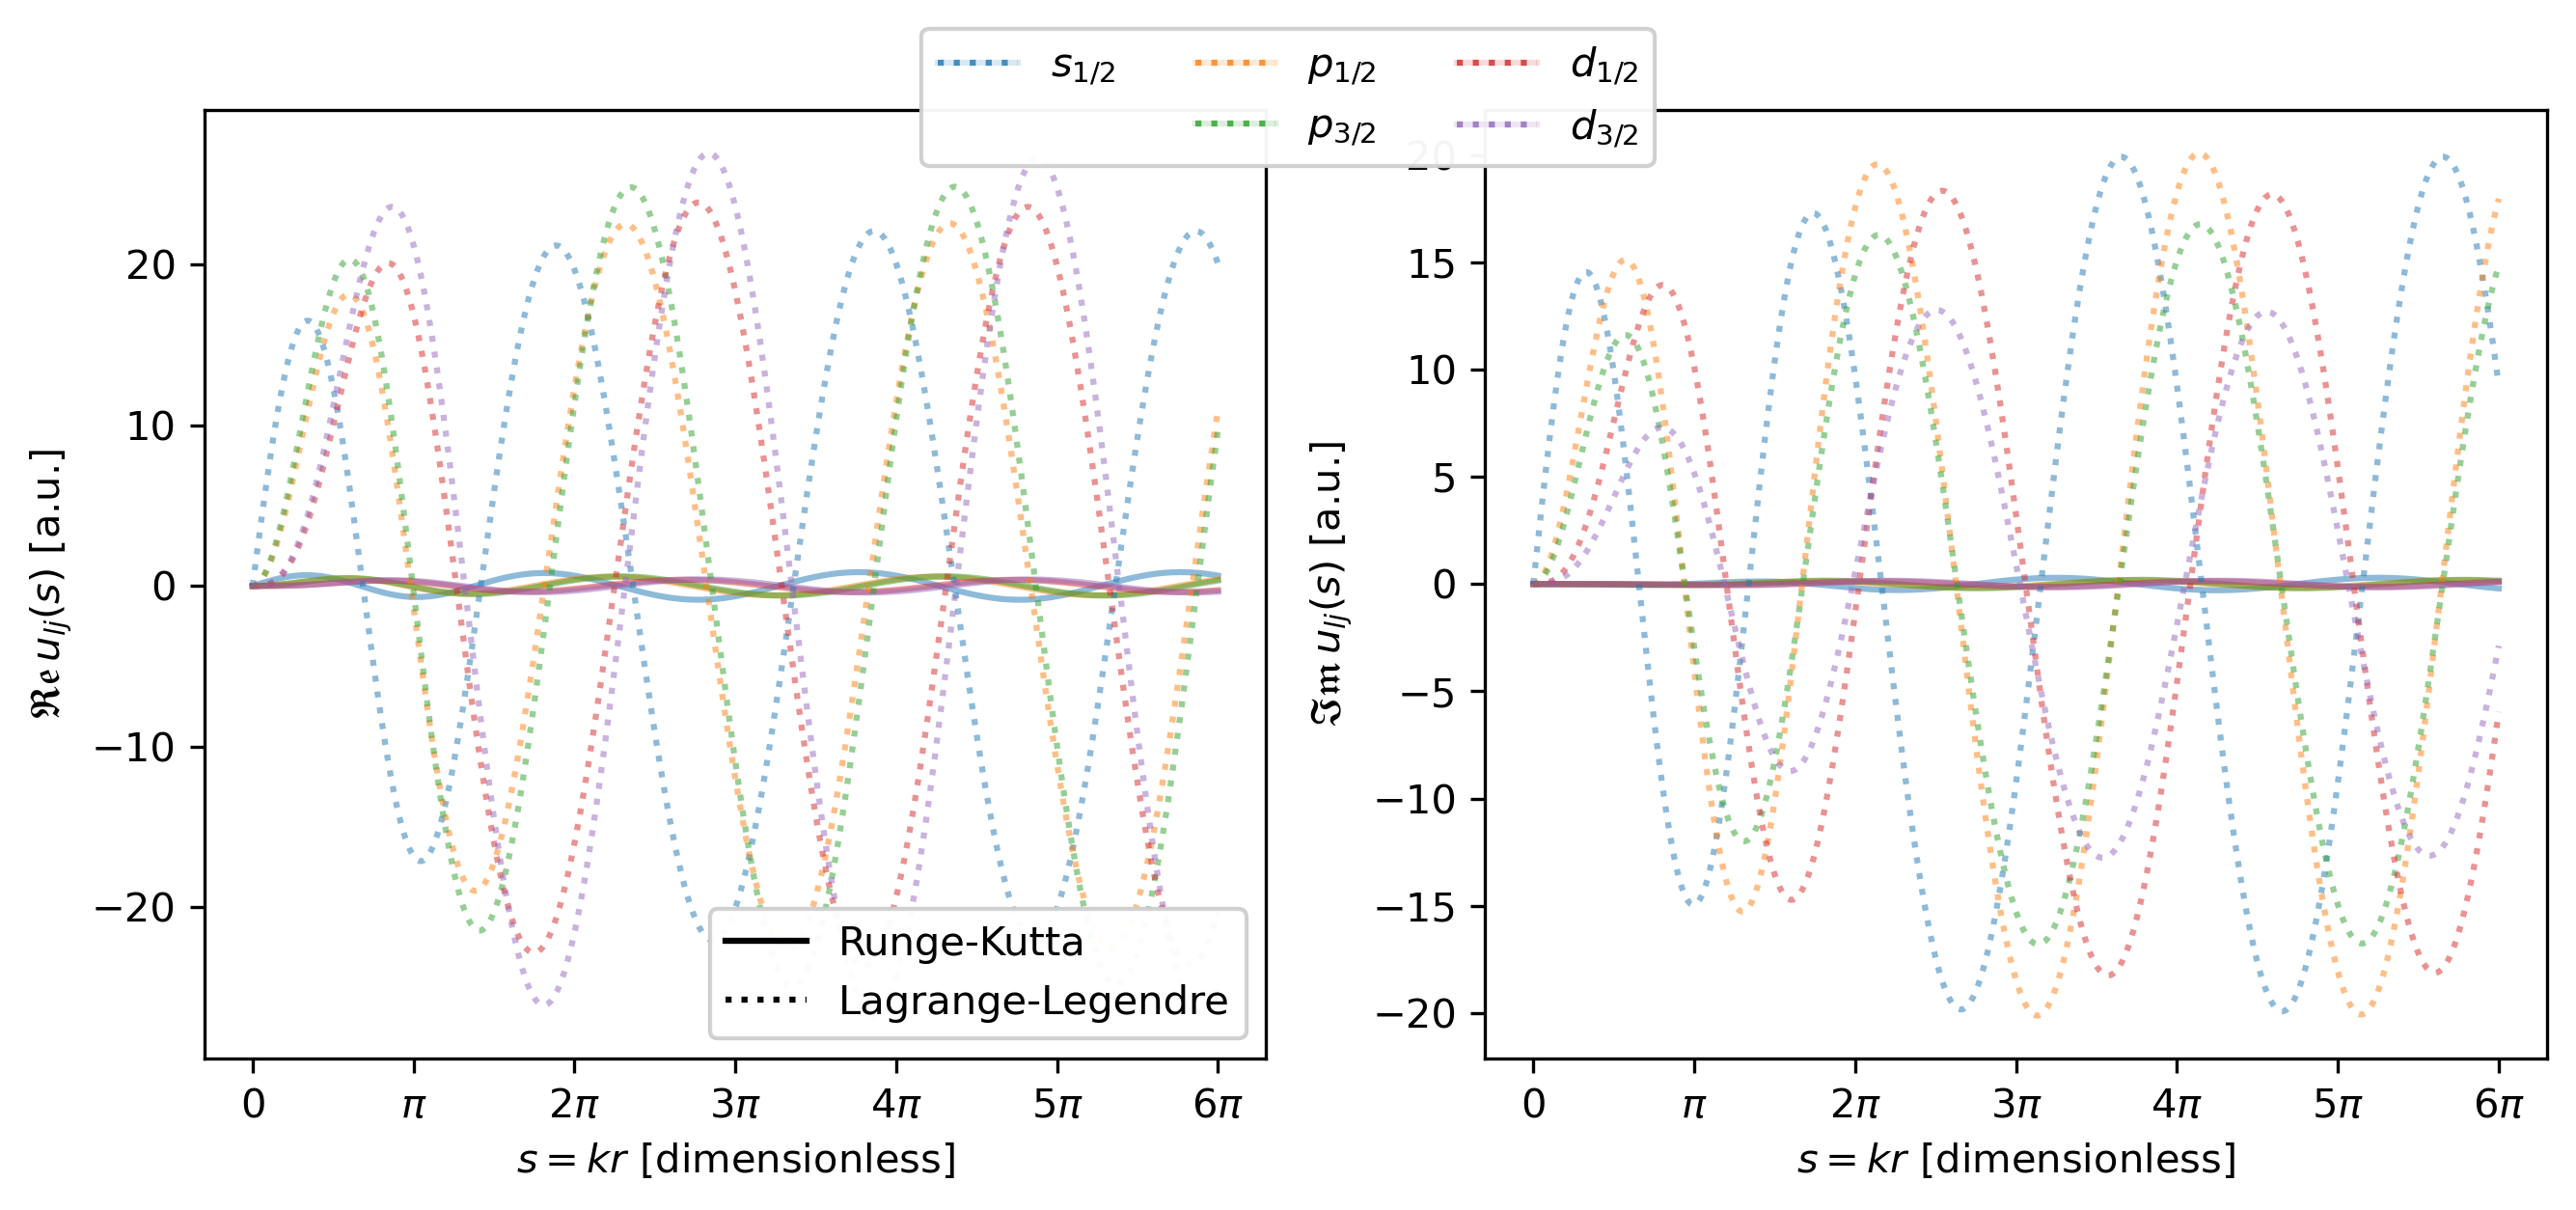

In [12]:
from rose.training import compare_partial_waves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=300)
fig.patch.set_facecolor("white")

compare_partial_waves(
    s_mesh,
    [solutions_rk[0:3], solutions_llrm[0:3]],
    ["Runge-Kutta", "Lagrange-Legendre"],
    fig,
    ax1,
    ax2,
)

Now, let's match phases and look again:

(<Figure size 2700x1200 with 2 Axes>,
 <AxesSubplot: xlabel='$s = kr$ [dimensionless]', ylabel='$\\mathfrak{Re} \\, u_{lj}(s)$ [a.u.]'>,
 <AxesSubplot: xlabel='$s = kr$ [dimensionless]', ylabel='$\\mathfrak{Im} \\, u_{lj}(s)$ [a.u.]'>)

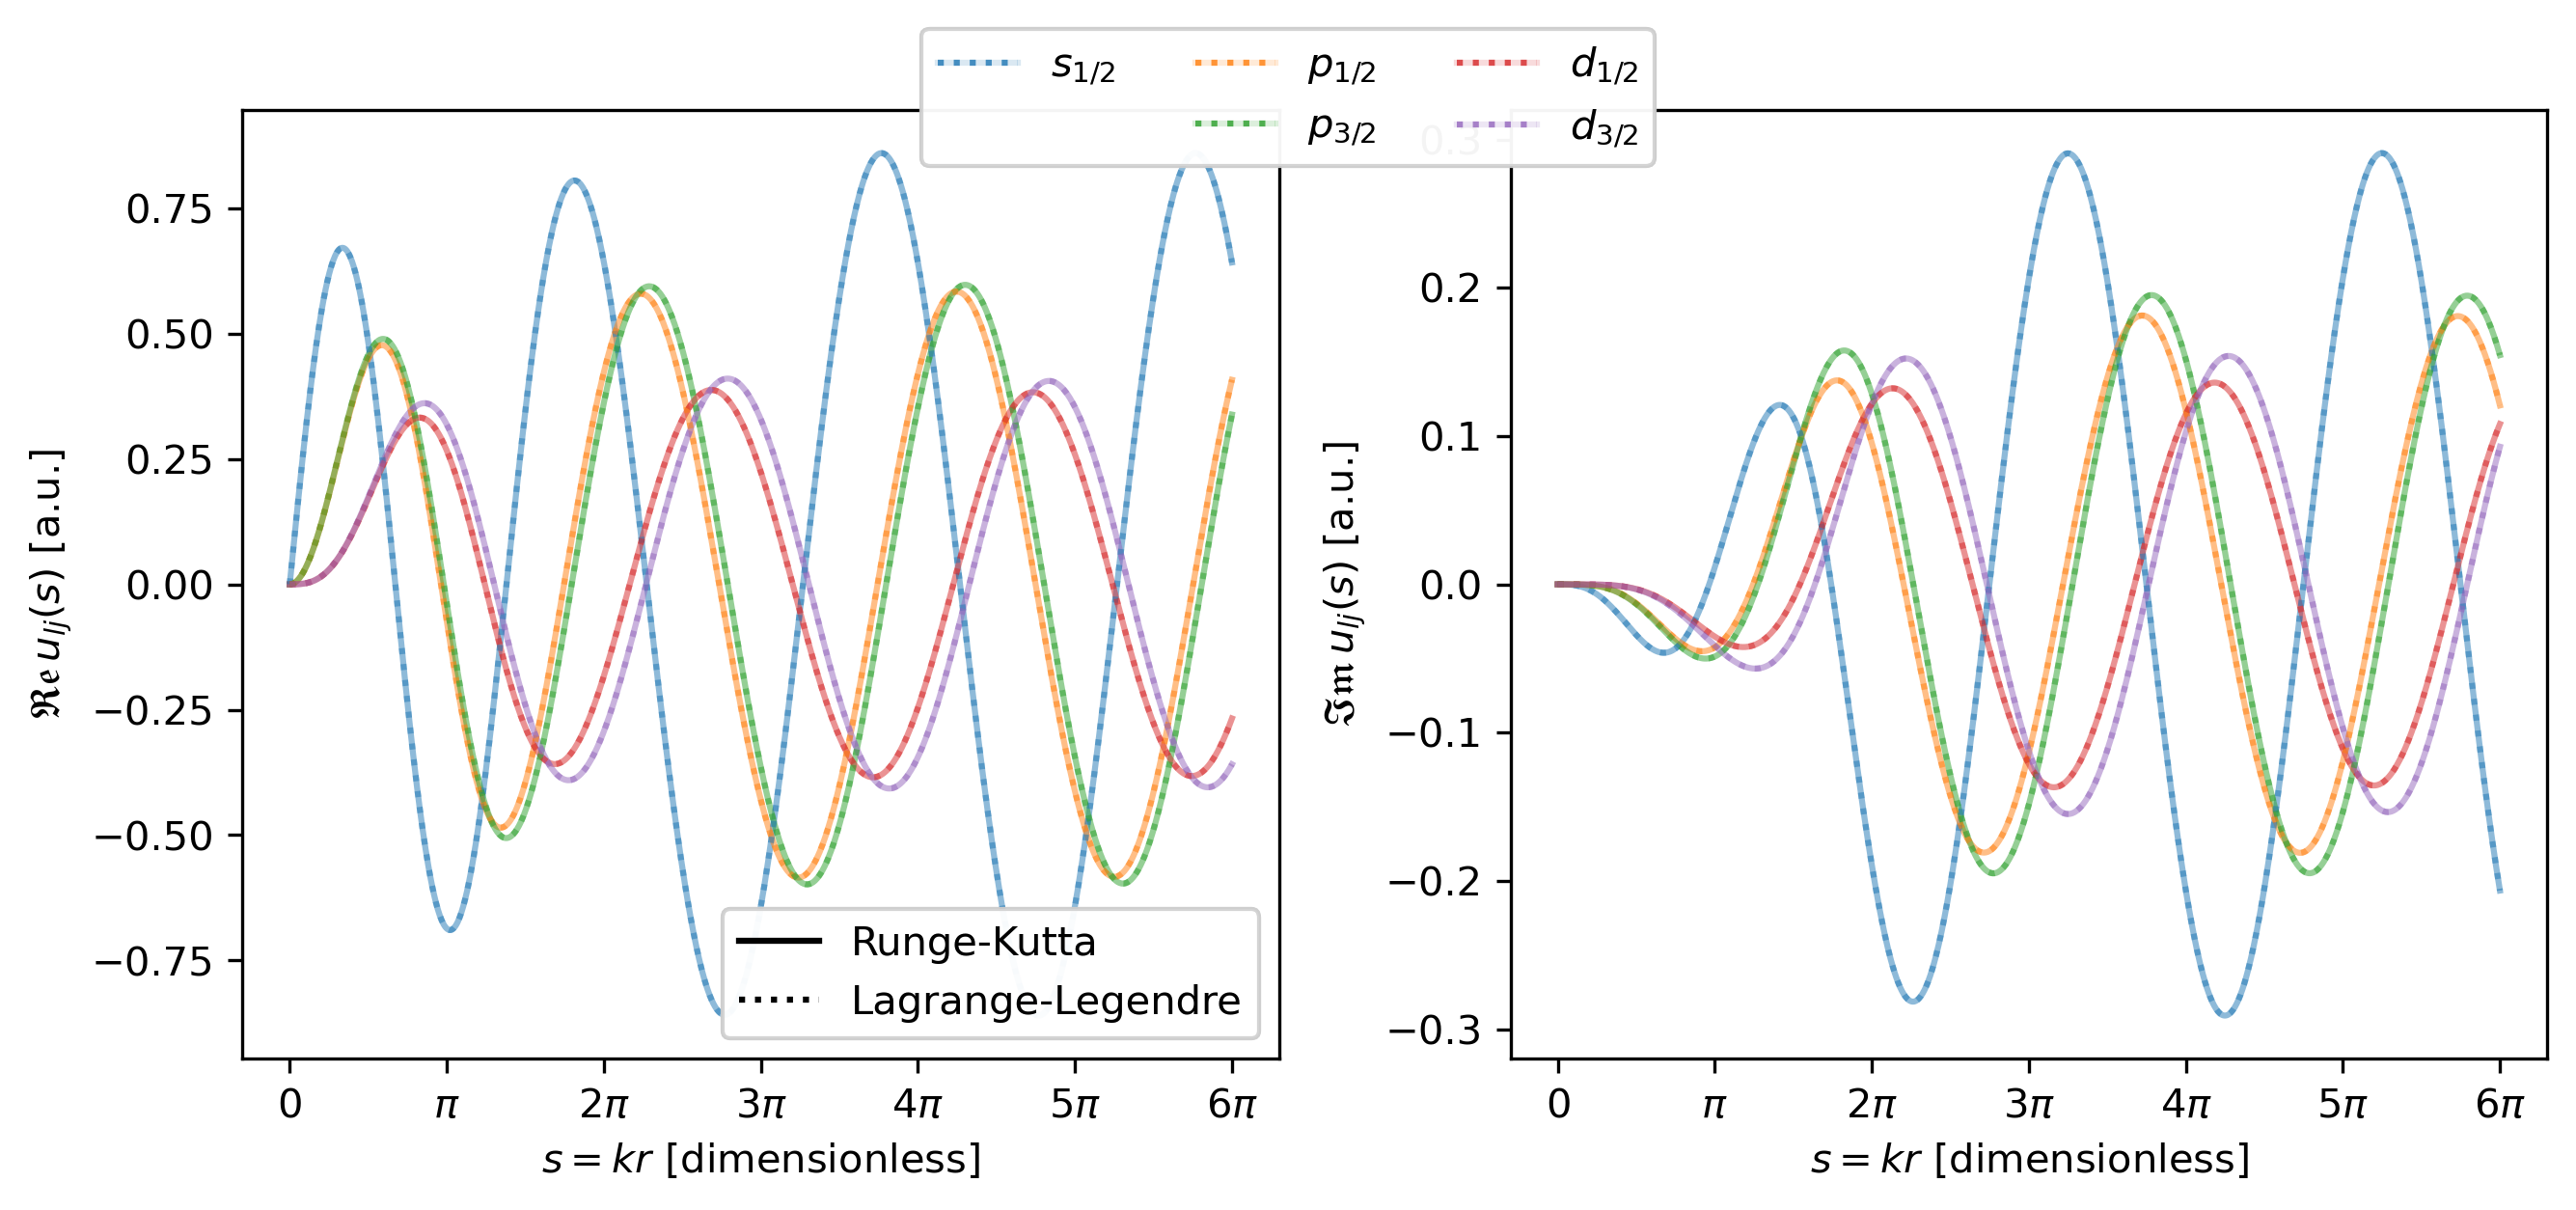

In [13]:
#TODO wavefunction normalization convention
for l in range(len(solutions_rk)):
    for j in range(len(solutions_rk[l])):
        i = np.argmax(solutions_rk[l][j])
        solutions_llrm[l][j] *= (
            solutions_rk[l][j][i] / solutions_llrm[l][j][i])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=300)
fig.patch.set_facecolor("white")

compare_partial_waves(
    s_mesh,
    [solutions_rk[0:3], solutions_llrm[0:3]],
    ["Runge-Kutta", "Lagrange-Legendre"],
    fig,
    ax1,
    ax2,
)

Now, let's take a look at phase shifts:

In [14]:
deltas_rk = ground_truth.exact_phase_shifts(parameters)

In [15]:
deltas_llrm = llrm.exact_phase_shifts(parameters)

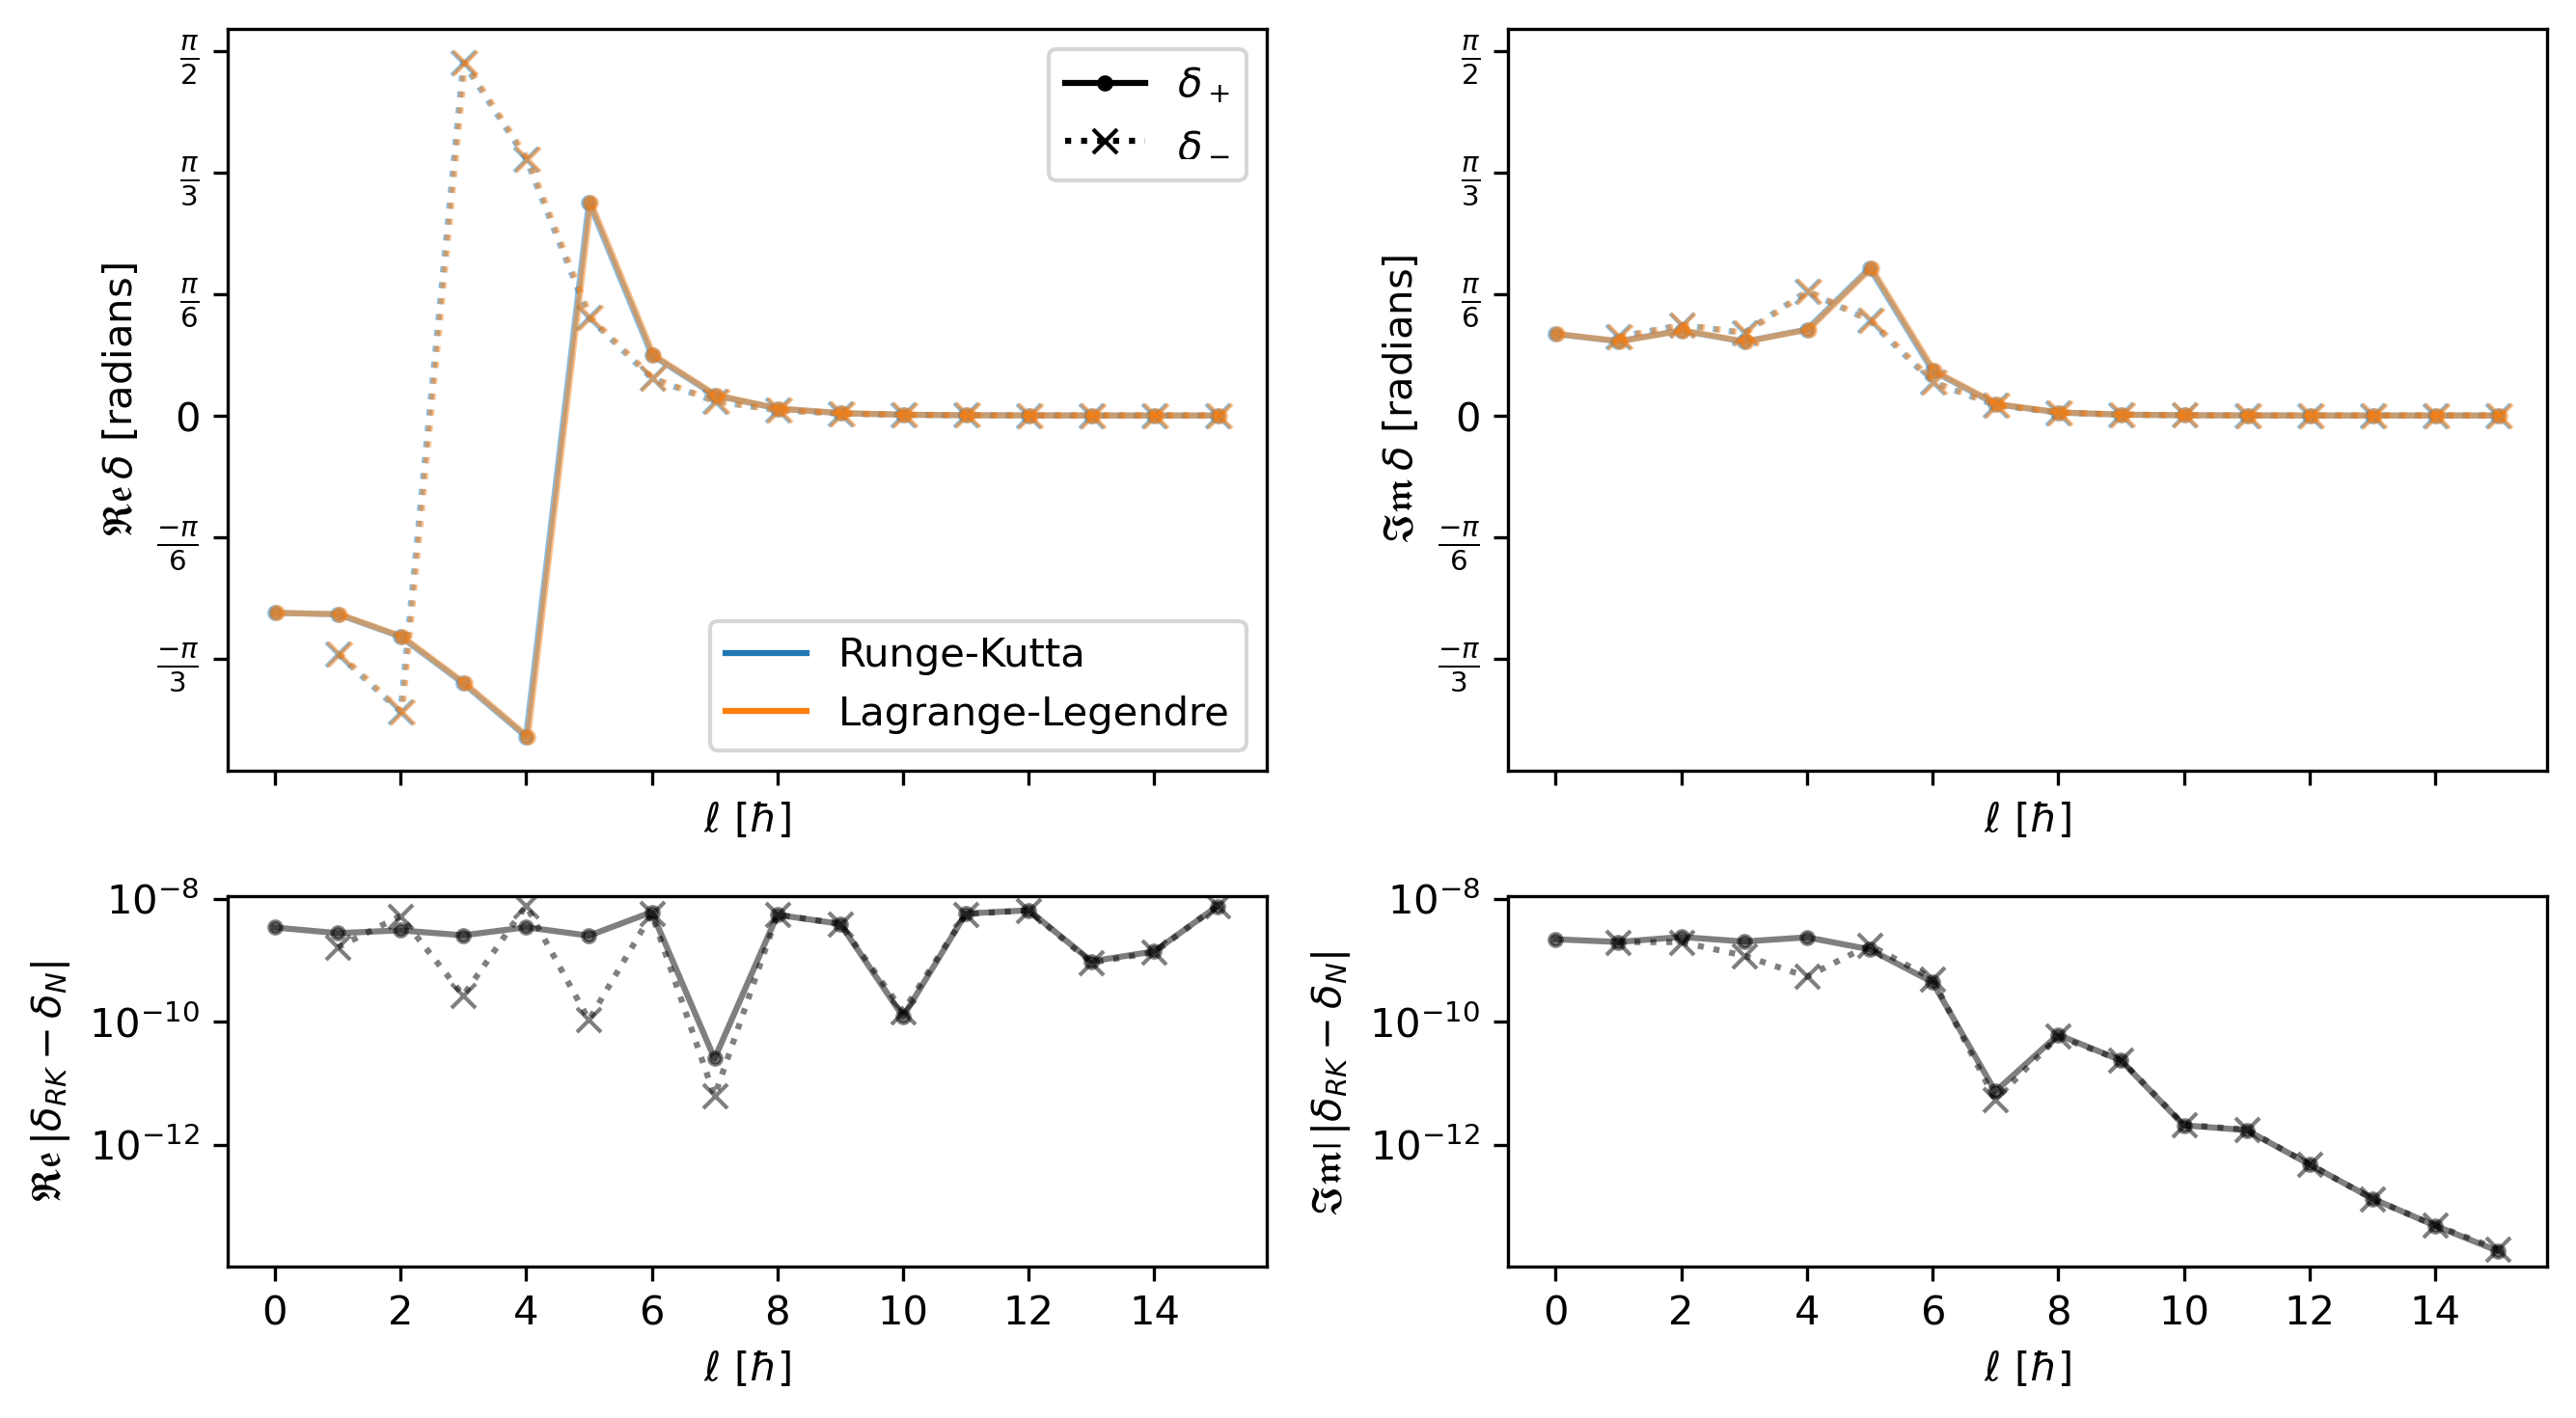

In [16]:
from rose.training import plot_phase_shifts, compare_phase_shifts_err
from matplotlib import ticker

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, sharex=True, figsize=(9, 5), height_ratios=[1, 0.5], dpi=300
)
fig.patch.set_facecolor("white")

compare_phase_shifts_err(
    deltas_rk,
    deltas_llrm,
    "Runge-Kutta",
    "Lagrange-Legendre",
    fig,
    ax1,
    ax2,
    ax3,
    ax4,
    small_label1="RK",
    small_label2="N",
)

plt.tight_layout()

In [17]:
rk_tolerances = [(1e-5, 1e-5), (1e-7, 1e-7), (1e-9, 1e-9)]
rk_solvers = []

for rk_tols in rk_tolerances:
    solver = rose.SchroedingerEquation.make_base_solver(
        rk_tols=rk_tols, s_0=s_0, domain=rk_domain
    )
    rk_solvers.append(
        rose.ScatteringAmplitudeEmulator.HIFI_solver(
            interactions, base_solver=solver, angles=angles, s_mesh=s_mesh
        )
    )

In [18]:
nbases = [30, 50, 100]
llrm_solvers = []
for n in nbases:
    solver = LagrangeRmatrix1ch(
        interactions.interactions[0][0],
        sys,
        n,
    )

    llrm_solvers.append(
        rose.ScatteringAmplitudeEmulator.HIFI_solver(
            interactions,
            base_solver=solver,
            angles=angles,
            s_mesh=s_mesh,
        )
    )


Not bad! How does this translate to cross sections? Let's calculate $d\sigma/d\Omega$ for various instances of our interaction with different parameters.

In [19]:
# grab some sample parameters
test_samples = rose.training.sample_params_LHC(100, parameters, 0.8, seed=1233)

In [20]:
%%time
# calculate ground truth differential cross sections for each sample
fpath = Path("ground_truth_rm_vs_rk_test.pkl")

if fpath.is_file():
    with open(fpath, 'rb') as f:
        ground_truth_output = pickle.load(f)
else:
    ground_truth_output = []
    for sample in tqdm(test_samples):
        ground_truth_output.append(ground_truth.exact_xs(sample).dsdo)
    with open(fpath, 'wb') as f:
        pickle.dump(ground_truth_output, f)

CPU times: user 0 ns, sys: 4.92 ms, total: 4.92 ms
Wall time: 839 µs


In [21]:
%%time
# calculate lowfi differential cross sections for each sample to compare
lowfi_solver = llrm_solvers[0]
lowfi_method = "Lagrange-Legendre n={}".format(nbases[0])

lowfi_output = []
for sample in tqdm(test_samples):
    lowfi_output.append(lowfi_solver.exact_xs(sample).dsdo)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.85it/s]

CPU times: user 5.34 s, sys: 10 s, total: 15.4 s
Wall time: 2.58 s


Text(0.5, 0, '$\\theta$ [radians]')

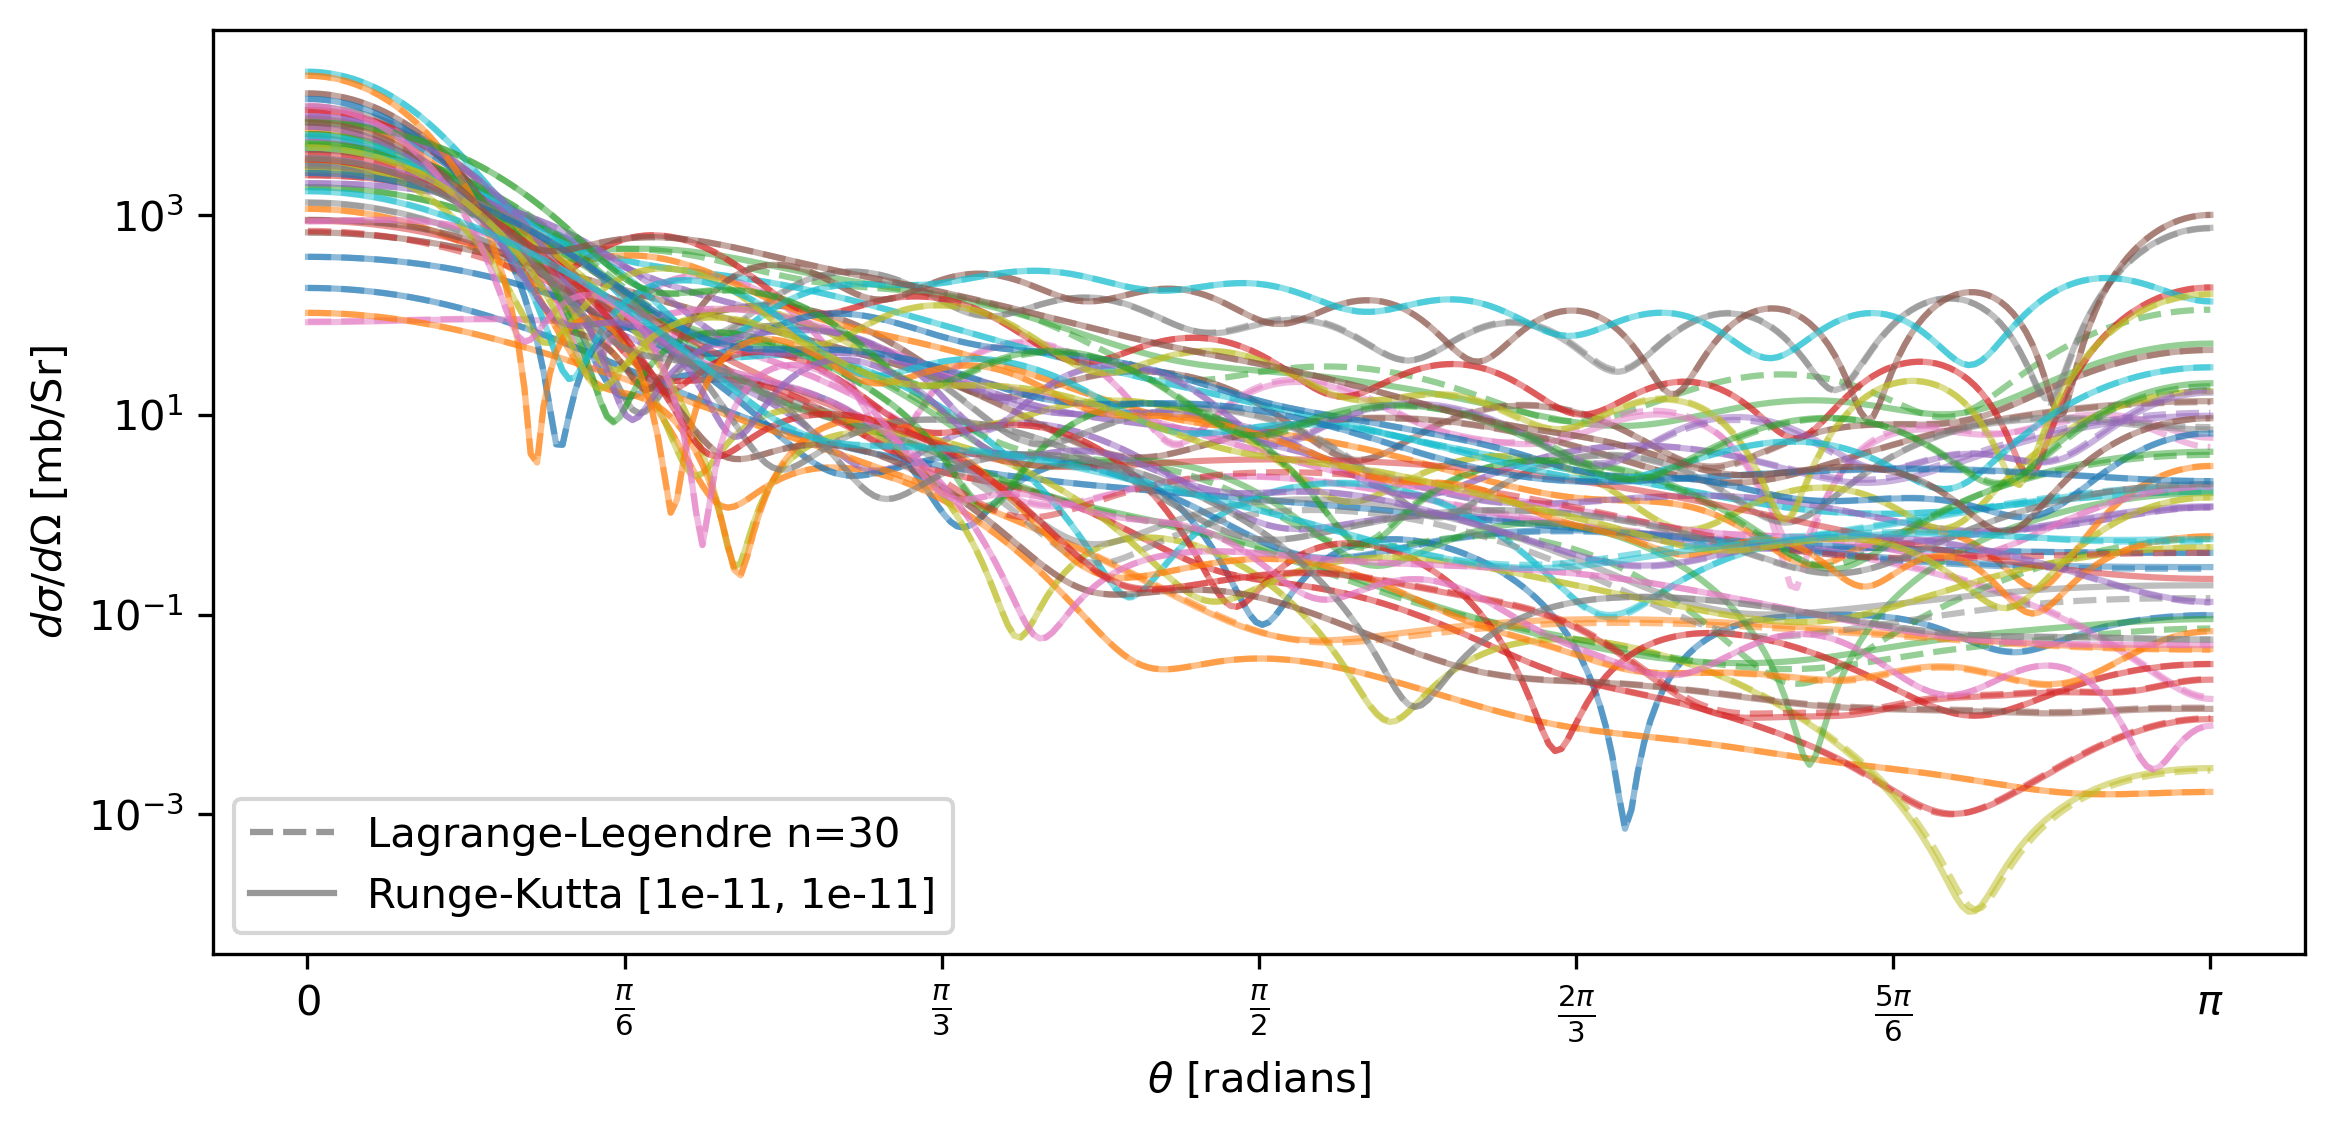

In [22]:
from matplotlib.lines import Line2D
from rose.training import multiple_formatter
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)
fig.patch.set_facecolor("white")

# only plot a few
n2plot = 10
for xs_hifi, xs_lowfi in zip(ground_truth_output[:n2plot], lowfi_output[:n2plot]):
    p = ax.plot(angles, xs_hifi, alpha=0.5)[0]
    ax.plot(angles, xs_lowfi, "--", color=p.get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="tab:gray", linestyle="--", alpha=0.8),
    Line2D([0], [0], color="tab:gray", alpha=0.8),
]
leg = plt.legend(
    legend_styles,
    [lowfi_method, "Runge-Kutta [1e-11, 1e-11]",],
    loc="lower left",
)

ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi/6))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=6)))
ax.set_yscale("log")
ax.set_ylabel(r"$ d \sigma / d\Omega $ [mb/Sr]")
ax.set_xlabel(r"$\theta$ [radians]")

Looks like $n=50$ is pretty darn good, but it does have a few cases with minor disagreements to the high fidelity. Let's quantify this with a CAT plot:

In [23]:
from rose.training import CATPerformance

In [24]:
%%time
rk_solver_performances = []
for solver, tols in zip(rk_solvers, rk_tolerances):
    label = r"$\left[{:1.0e} , {:1.0e}\right]$".format(*tols)
    fpath = Path("perf_rk_{:1.0e}_{:1.0e}.pkl".format(*tols))
    if fpath.is_file():
        with open(fpath, 'rb') as f:
            perf = pickle.load(f)
            rk_solver_performances.append(perf)
    else:
        rk_solver_performances.append(
            CATPerformance(
                benchmark_runner=lambda sample: solver.exact_xs(sample).dsdo,
                benchmark_inputs=test_samples,
                benchmark_ground_truth=ground_truth_output,
                label=label,
            )
        )
        with open(fpath, 'wb') as f:
            pickle.dump(rk_solver_performances[-1], f)

CPU times: user 540 µs, sys: 506 µs, total: 1.05 ms
Wall time: 902 µs


In [25]:
%%time
llrm_solver_performances = []
for solver, n in zip(llrm_solvers, nbases):
    label = r"$N  = {}$".format(n)
    fpath = Path("perf_llrm_N_{}.pkl".format(n))
    if fpath.is_file():
        with open(fpath, "rb") as f:
            perf = pickle.load(f)
            llrm_solver_performances.append(perf)
    else:
        llrm_solver_performances.append(
            CATPerformance(
                benchmark_runner=lambda sample: solver.exact_xs(sample).dsdo,
                benchmark_inputs=test_samples,
                benchmark_ground_truth=ground_truth_output,
                label=label,
            )
        )
        with open(fpath, "wb") as f:
            pickle.dump(llrm_solver_performances[-1], f)

CPU times: user 0 ns, sys: 1.63 ms, total: 1.63 ms
Wall time: 1.17 ms


(0.001, 100)

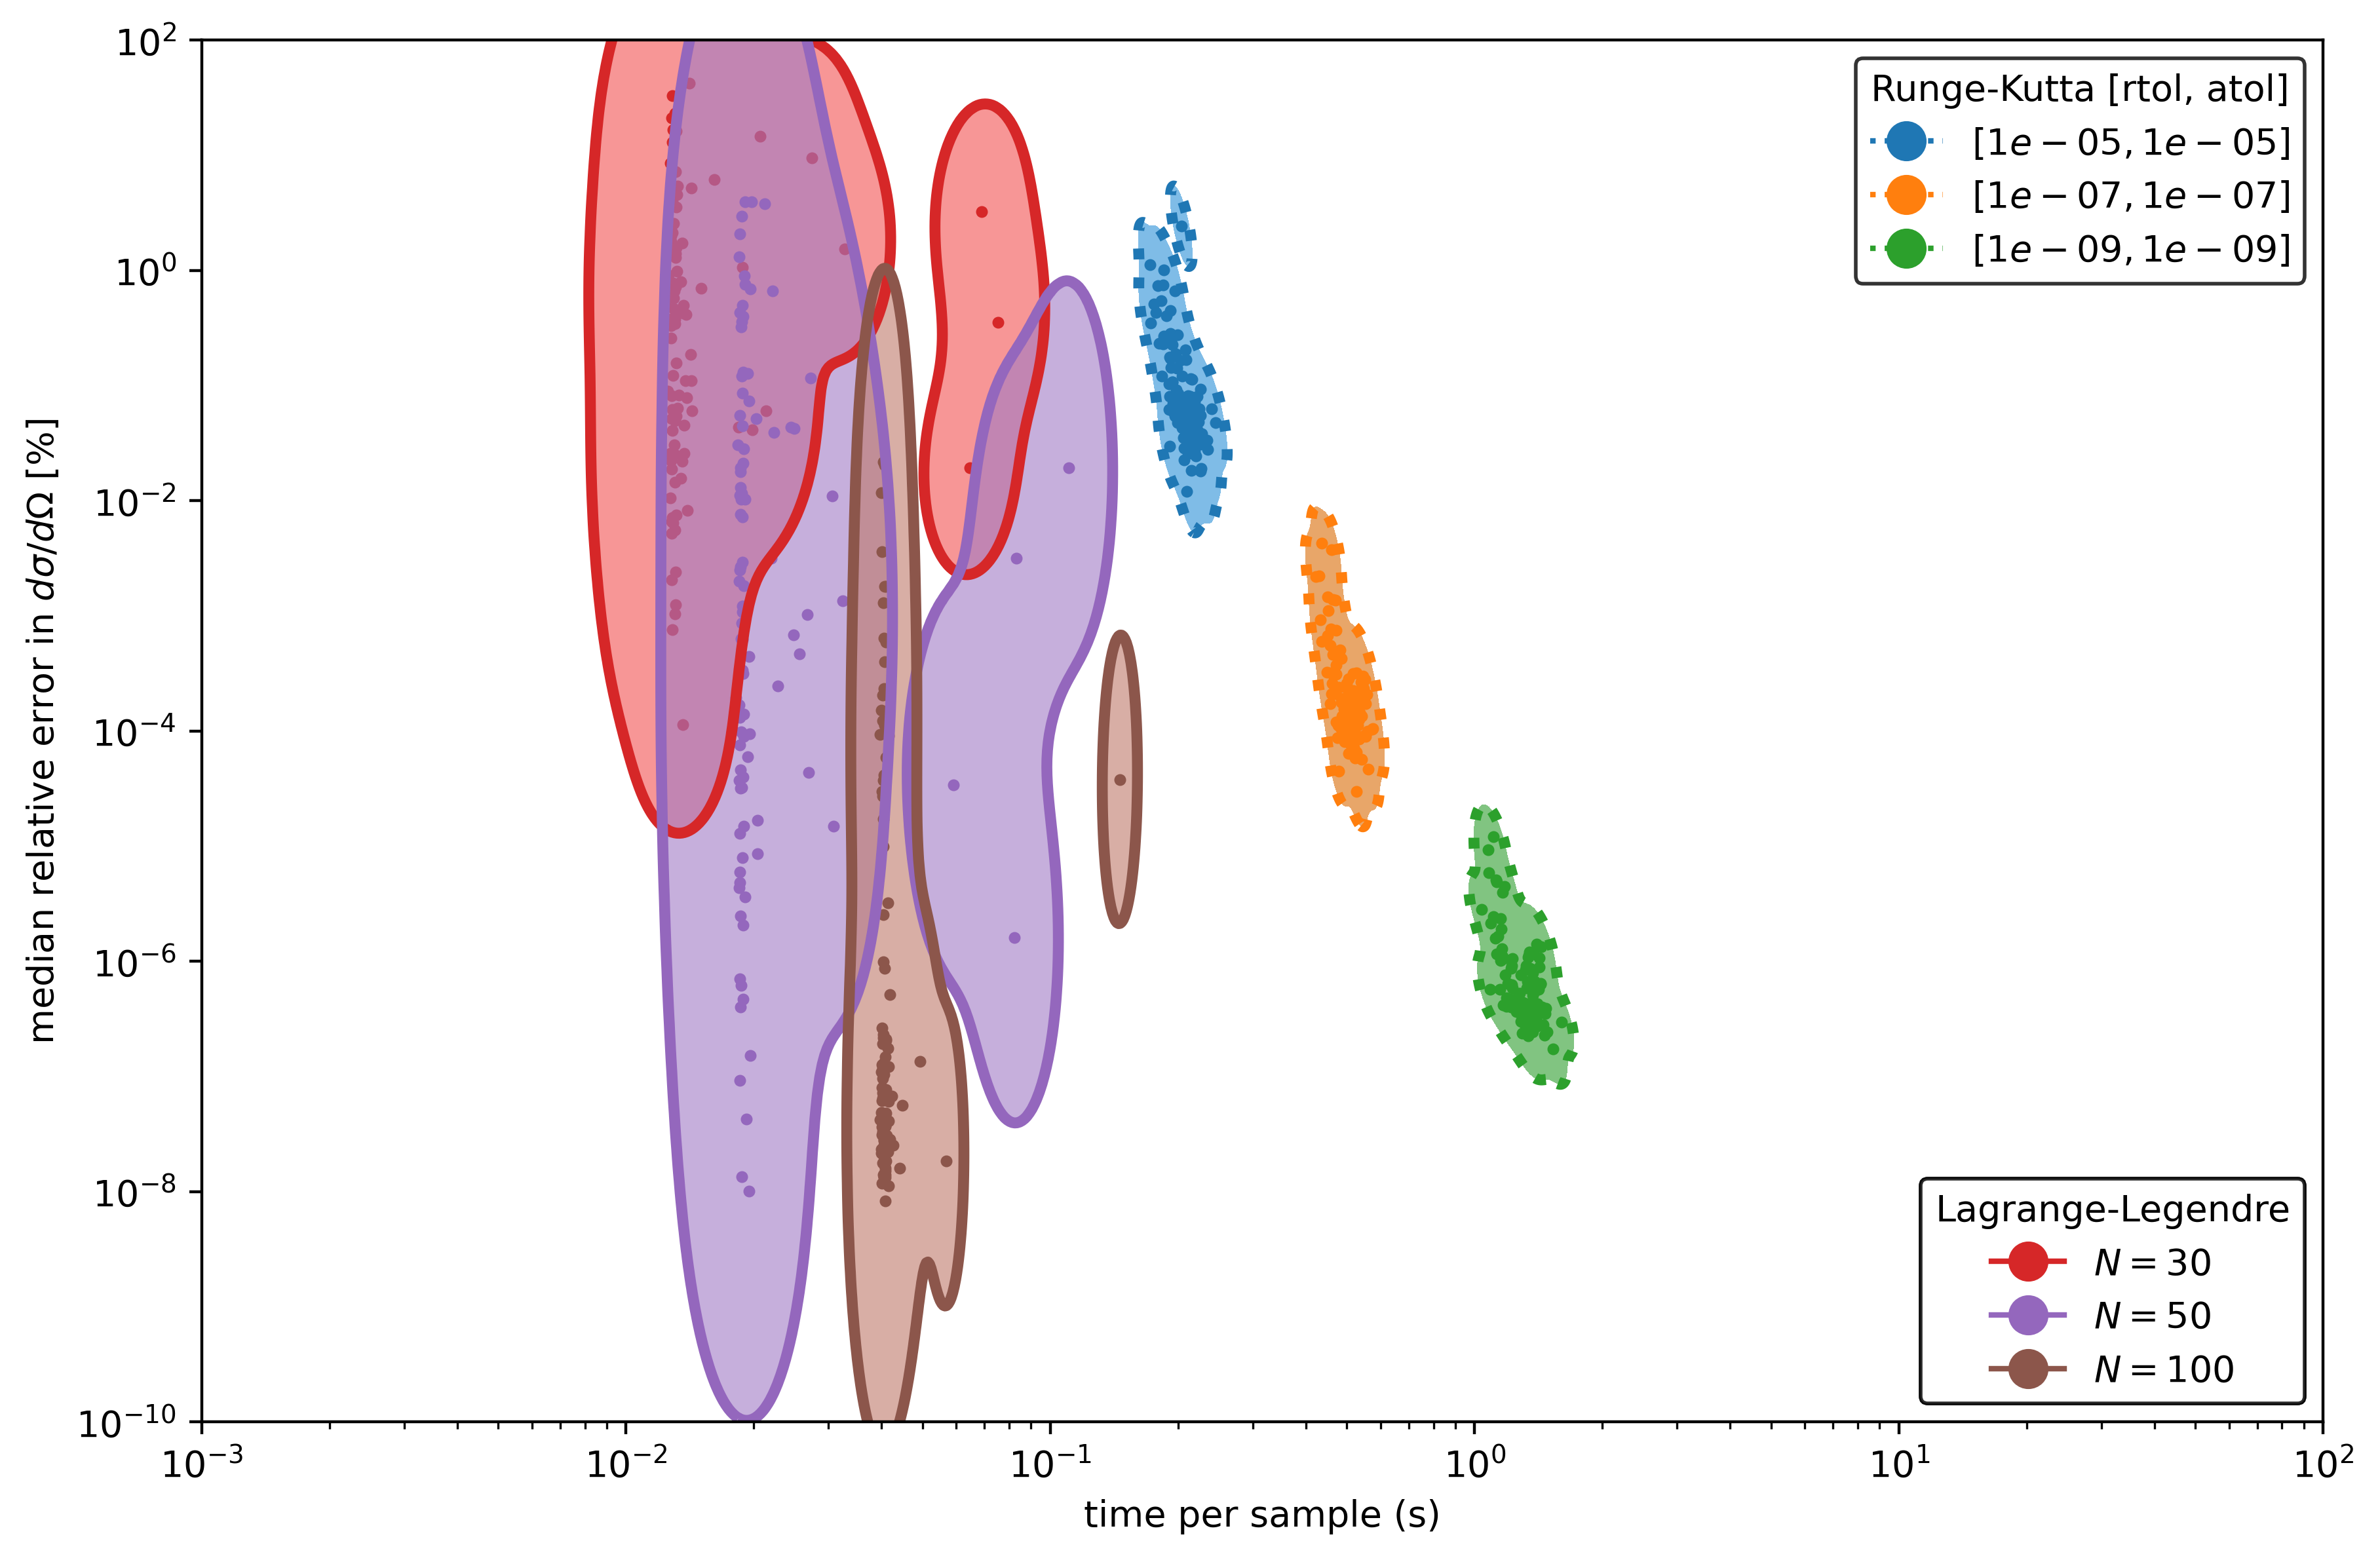

In [27]:
# plot the Computational Accuracy vs. Time (CAT)
from rose.training import CAT_plot

fig, ax = CAT_plot(
    [rk_solver_performances, llrm_solver_performances],
    labels=["Runge-Kutta [rtol, atol]", "Lagrange-Legendre"],
    border_styles=[":", "-"],
)
ax.set_ylabel(r"median relative error in $d \sigma / d \Omega$ [%]")
ax.set_ylim(1e-10,100)
ax.set_xlim(1e-3,100)

Great! It looks like using this Lagrange-Legendre method could save us a lot of time in training. For most purposes, $n \sim 100$ should be good, with less than 0.1% median relative error across all samples, and a ~1-1.5 order of magnitude speed up from the Runge-Kutta solvers.